In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, Flatten
from tensorflow.keras.layers import Permute, Multiply, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from sklearn.model_selection import ParameterGrid
!pip install yfinance
import yfinance as yf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=317865 sha256=4c92336dd16e1bba2227de25535f11373194d38258bea048b2c603ec6bf80675
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


## Long Short Term Memory(LSTM)
Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968)

The best LSTM explanation on internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Refer above link for deeper insights.

## Components of LSTMs
So the LSTM cell contains the following components
* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)

* Inputs to the LSTM cell at any step are X<sub>t</sub> (current input) , H<sub>t-1</sub> (previous hidden state ) and C<sub>t-1</sub> (previous memory state).  
* Outputs from the LSTM cell are H<sub>t</sub> (current hidden state ) and C<sub>t</sub> (current memory state)

## Working of gates in LSTMs
First, LSTM cell takes the previous memory state C<sub>t-1</sub> and does element wise multiplication with forget gate (f) to decide if  present memory state C<sub>t</sub>. If forget gate value is 0 then previous memory state is completely forgotten else if forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**C<sub>t</sub> = C<sub>t-1</sub> * f<sub>t</sub>**

Calculating the new memory state: 

**C<sub>t</sub> = C<sub>t</sub> + (I<sub>t</sub> * C\`<sub>t</sub>)**

Now, we calculate the output:

**H<sub>t</sub> = tanh(C<sub>t</sub>)**

### LSTM on Dow Jones

In [2]:
dow_yf = yf.Ticker("DJI")

In [3]:
dow_yf = dow_yf.history(period="max")

In [4]:
dow_yf.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,12987.000000,12987.000000,12987.000000,12987.000000,1.298700e+04,12987.0,12987.0
mean,7859.650956,7861.244658,7857.834178,7859.607759,1.609198e+07,0.0,0.0
std,7932.343211,7935.760479,7928.469577,7932.238067,6.155468e+07,0.0,0.0
min,577.599976,577.599976,577.599976,577.599976,0.000000e+00,0.0,0.0
25%,1030.369995,1030.369995,1030.369995,1030.369995,0.000000e+00,0.0,0.0
50%,4727.279785,4727.279785,4727.279785,4727.279785,0.000000e+00,0.0,0.0
75%,11209.799805,11209.799805,11209.799805,11209.799805,0.000000e+00,0.0,0.0
max,36799.699219,36799.699219,36799.699219,36799.699219,7.582325e+08,0.0,0.0


In [5]:
len(dow_yf)

12987

In [6]:
def create_tuples(dta, k):
    X = []
    y = []
    for i in range(k, dta.shape[0]):
        X.append(dta[i-k:i])
        y.append(dta[i, 0])
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [7]:
def lstm_stock_model(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=64, first_layer=60):
    model = Sequential()
    model.add(LSTM(units=first_layer, activation = 'relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, activation = 'relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=80, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

    # Train the model
    model.fit(X_train, y_train, validation_data = (X_dev, y_dev), epochs=epochs)
    
    return model

In [8]:
def k_fold_LSTM_s(dow_jones, epochs=20, k = 60):
    models = []
    errors = []
    
    # Step 1: Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)  # Assuming column 4 is 'Close'
    
    for i in range(4):
        print(f"Training {i+1}th model")
        
        # Step 2: Use pre-scaled data for splitting train/test sets
        test_start_idx = int(len(dow_jones) * (i * 0.2))
        test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
        
        test_close = dow_jones_scaled[test_start_idx:test_end_idx]
        train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
        
        # Step 3: Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        # Step 4: Train the model
        model = lstm_stock_model(X_train, y_train, X_test, y_test, epochs, 40)
        models.append(model)
        
        # Step 5: Predict and calculate MAE for the current fold
        y_pred = model.predict(X_test)
        
        # Step 6: Inverse scaling to get predictions back to the original price scale
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler


In [9]:
def k_search(dow_jones, epochs = 20):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_LSTM_s(dow_jones, epochs, k)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors)
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [10]:
#mean_error, model_list, scalers = k_search(dow_yf, 25)

In [11]:
#mean_error

In [12]:
def save_model_reg(model_list):
    u_values = ['m1_10_reg', 'm2_10_reg', 'm3_10_reg', 'm4_10_reg', 'm1_30_reg', 'm2_30_reg', 'm3_30_reg', 'm4_30_reg', 'm1_60_reg', 'm2_60_reg', 'm3_60_reg', 'm4_60_reg']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1
        

In [13]:
#save_model_reg(model_list)

In [14]:
def evaluate_test_set(scaler, models, dow_jones, k = 60):
    test_start_idx = int(len(dow_jones) * 0.8)
    test_end_idx = int(len(dow_jones))
    
    final_df = dow_jones.iloc[test_start_idx:test_end_idx, 3:4].values  # Only taking the 'Close' column
    
    input_data = scaler.transform(final_df)
    
    X_dev_t, y_dev_t = create_tuples(input_data, k)
    
    y_preds = []
    for model in models:
        y_pred = model.predict(X_dev_t)
        y_preds.append(y_pred)
    
    y_pred_f = np.zeros_like(y_preds[0])
    for num in y_preds:
        y_pred_f = y_pred_f+num
    
    # Average the predictions
    y_pred_f /= len(models)
    y_pred_s = scaler.inverse_transform(y_pred_f.reshape(-1, 1))
    y_dev_s = scaler.inverse_transform(y_dev_t.reshape(-1, 1))
    
    plt.figure(figsize=(12,6))
    plt.plot(y_dev_s, 'b', label="Original Price")
    plt.plot(y_pred_s, 'r', label="Predicted Price")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
    # Calculate mean absolute error
    mae = mean_absolute_error(y_dev_s, y_pred_s)
    print("Mean absolute error on test set: ", mae)
    return y_preds


In [15]:
def predict_value_index(model, test_df, k = 90):
    print(f"Testing for k = {k} model")
    test_end_idx = int(len(test_df))
    test_dow_jones = test_df.iloc[0:test_end_idx]
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_close = test_dow_jones.iloc[:, 4:5].values
    dta = scaler.fit_transform(test_close)
    X_test, y_test = create_tuples(dta, k)
    test_df = pd.DataFrame(test_close)
    final_df = test_df
    input_data = scaler.fit_transform(final_df)
    X_dev_t, y_dev_t = create_tuples(input_data, k)
    final_df_np = np.array(final_df)
    X_dev_us_t, y_dev_us_t = create_tuples(final_df_np, k)
    y_pred = model_90.predict(X_test)
    scale_factor = 1/scaler.scale_
    y_pred_s = scaler.inverse_transform(y_pred)
    mae = mean_absolute_error(y_dev_us_t[k:], y_pred_s[k:])
    print(f"Mean absolute error for k = {k}:{mae} ")
    return y_dev_us_t[k:], y_pred_s[k:]
    

In [16]:
def plot_predictions(y_orig, y_pred):
    plt.figure(figsize=(12,6))
    plt.plot(y_orig, 'b', label="Original Price")
    plt.plot(y_pred, 'r', label="Predicted Price")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

### Trying out a smaller model

In [17]:
def lstm_stock_model_small(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=128, first_layer=40):
    model = Sequential()
    model.add(LSTM(units=first_layer, activation = 'relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, activation = 'relu', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

    model.fit(X_train, y_train, validation_data = (X_dev, y_dev), epochs=epochs)
    
    return model

In [18]:
def k_fold_LSTM_small(dow_jones, epochs=20, k=60, n_splits=4):
    models = []
    errors = []
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)  

    # Use KFold to split the data into train/test sets
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Shuffle for randomness

    for i, (train_idx, test_idx) in enumerate(kf.split(dow_jones_scaled)):
        print(f"Training {i+1}th model")
        
        train_close = dow_jones_scaled[train_idx]
        test_close = dow_jones_scaled[test_idx]
        
        # Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = lstm_stock_model_small(X_train, y_train, X_test, y_test, epochs)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler

In [19]:
train_idx = int(len(dow_yf) * 0.8)
dow_yf_train = dow_yf[0:train_idx]
dow_yf_test = dow_yf[train_idx:]


In [20]:
def k_search_small(dow_jones, epochs = 20):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_LSTM_small(dow_jones, epochs, k,4)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [21]:
#mean_error, model_list, scalers = k_search_small(dow_yf_train, 25)

In [22]:
#mean_error

In [23]:
def save_model_small(model_list):
    u_values = ['m1sm_10_yf', 'm2sm_10_yf', 'm3sm_10_yf', 'm4sm_10_yf', 'm1sm_30_yf', 'm2sm_30_yf', 'm3sm_30_yf', 'm4sm_30_yf', 'm1sm_60_yf', 'm2sm_60_yf', 'm3sm_60_yf', 'm4sm_60_yf']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1
        

In [24]:
#save_model_small(model_list)

In [25]:
def predict_value_index_mulmodels(models, test_df, k=90, yahoo_data = 'N'):
    print(f"Testing for k = {k} models")
    test_end_idx = int(len(test_df))
    test_dow_jones = test_df.iloc[0:test_end_idx]
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(yahoo_data == 'N'):
        test_close = test_dow_jones.iloc[:, 4:5].values
    else:
        test_close = test_dow_jones.iloc[:, 3:4].values
    dta = scaler.fit_transform(test_close)
    X_test, y_test = create_tuples(dta, k)
    y_pred_sum = np.zeros((X_test.shape[0], 1))

    for model in models:
        y_pred = model.predict(X_test)
        y_pred_sum += y_pred
    
    y_pred_avg = y_pred_sum / len(models)
    
    y_pred_s = scaler.inverse_transform(y_pred_avg)
    y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  
    mae = mean_absolute_error(y_test_s, y_pred_s)
    print(f"Mean absolute error for k = {k}: {mae}")

    return y_test_s, y_pred_s


In [26]:
def test_on_index_and_plot_small_model(df, k = 60, yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/small_lstm_10_30_60_dow_yf/keras/default/1/m{i}sm_{k}_yf.h5'))
    y_orig, y_pred = predict_value_index_mulmodels_small(models, df, k, yahoo_data)
    plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

## Intro to Bidirectional LSTMs

<center>
<img src="https://miro.medium.com/v2/resize:fit:764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png" width=800 height=500 />
</center>


Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. Unlike standard LSTM, the input flows in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

In summary, BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer. Then we combine the outputs from both LSTM layers in several ways, such as average, sum, multiplication, or concatenation.

### Training a Bidirectional LSTM

In [27]:
dow = yf.Ticker("DJI")

In [28]:
dow_yf = dow.history(period="max")

In [29]:
dow_yf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1970-01-02 00:00:00-05:00,809.200012,809.200012,809.200012,809.200012,0,0.0,0.0
1970-01-05 00:00:00-05:00,811.309998,811.309998,811.309998,811.309998,0,0.0,0.0
1970-01-06 00:00:00-05:00,803.659973,803.659973,803.659973,803.659973,0,0.0,0.0
1970-01-07 00:00:00-05:00,801.809998,801.809998,801.809998,801.809998,0,0.0,0.0
1970-01-08 00:00:00-05:00,802.070007,802.070007,802.070007,802.070007,0,0.0,0.0
...,...,...,...,...,...,...,...
2022-02-24 00:00:00-05:00,33223.800781,33223.800781,33223.800781,33223.800781,0,0.0,0.0
2022-02-25 00:00:00-05:00,34058.800781,34058.800781,34058.800781,34058.800781,0,0.0,0.0
2022-02-28 00:00:00-05:00,33892.601562,33892.601562,33892.601562,33892.601562,0,0.0,0.0


In [30]:
dow_yf.iloc[:, 3:4].values

array([[  809.20001221],
       [  811.30999756],
       [  803.65997314],
       ...,
       [33892.6015625 ],
       [33294.8984375 ],
       [33891.30078125]])

In [31]:
def bi_lstm(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=128, first_layer=60):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=first_layer, activation = 'tanh', input_shape=(X_train.shape[1], 1))))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

    # Train the model
    model.fit(X_train, y_train, validation_data = (X_dev, y_dev), epochs=epochs)
    
    return model

In [32]:
def k_fold_biLSTM(dow_jones, epochs=20, k=60, n_splits=4, ss = 'N'):
    models = []
    errors = []
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(ss == 'N'):
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)

    # Use KFold to split the data into train/test sets
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Shuffle for randomness

    for i, (train_idx, test_idx) in enumerate(kf.split(dow_jones_scaled)):
        print(f"Training {i+1}th model")
        
        #Use indices to create train/test sets
        train_close = dow_jones_scaled[train_idx]
        test_close = dow_jones_scaled[test_idx]
        
        #Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = bi_lstm(X_train, y_train, X_test, y_test, epochs, k)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler

In [33]:
def k_search_bi_LSTM(dow_jones, epochs = 20, ss = 'N'):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_biLSTM(dow_jones, epochs, k, 4, ss)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [34]:
#mean_error, model_list, scalers = k_search_bi_LSTM(dow_yf, 20, 'Y')


In [35]:
#mean_error

In [36]:
def save_model_biLSTM(model_list):
    u_values = ['m1yf_10', 'm2yf_10', 'm3yf_10', 'm4yf_10', 'm1yf_30', 'm2yf_30', 'm3yf_30', 'm4yf_30', 'm1yf_60', 'm2yf_60', 'm3yf_60', 'm4syf_60']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1

In [37]:
#save_model_biLSTM(model_list)

### Training a hybrid model of LSTM and GRU
#### This hybrid model combines the strengths of LSTM and GRU layers, where the LSTM effectively captures long-term dependencies, and the GRU improves training efficiency with its simpler gating mechanism. This combination aims to balance model complexity and computational speed while handling intricate temporal patterns in the data.

In [38]:
def lstm_gru_hybrid_stock_model(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=128, first_layer=40):
    model = Sequential()
    model.add(LSTM(units=first_layer, activation = 'tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=60, activation = 'relu', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

    model.fit(X_train, y_train, validation_data = (X_dev, y_dev), epochs=epochs)
    
    return model

In [39]:
def k_fold_LSTM_GRU_hybrid(dow_jones, epochs=20, k = 60, ss='N'):
    models = []
    errors = []
    
    #Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(ss == 'Y'):
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)
    
    for i in range(4):
        print(f"Training {i+1}th model")
        
        test_start_idx = int(len(dow_jones) * (i * 0.2))
        test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
        
        test_close = dow_jones_scaled[test_start_idx:test_end_idx]
        train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
        
        #Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = lstm_gru_hybrid_stock_model(X_train, y_train, X_test, y_test, epochs, 128, 40)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler


In [40]:
def k_search_LSTM_GRU_hybrid(dow_jones, epochs = 20, ss = 'Y'):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_LSTM_GRU_hybrid(dow_jones, epochs, k, ss)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [41]:
#mean_error, model_list, scalers = k_search_LSTM_GRU_hybrid(dow_yf, 25, 'Y')

In [42]:
#mean_error

In [43]:
def save_model_LSTM_GRU_hybrid(model_list):
    u_values = ['m1hy_10', 'm2hy_10', 'm3hy_10', 'm4hy_10', 'm1hy_30', 'm2hy_30', 'm3hy_30', 'm4hy_30', 'm1hy_60', 'm2hy_60', 'm3hy_60', 'm4hy_60']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1

In [44]:
#save_model_LSTM_GRU_hybrid(model_list)

### Training a hybrid model of Bidirectional LSTM and GRU
#### This hybrid model leverages the strengths of both Bidirectional LSTM and GRU, where the Bidirectional LSTM captures temporal dependencies in both forward and backward directions, and the GRU adds efficiency with fewer parameters. Together, they provide a powerful framework for modeling complex sequential patterns with reduced computational overhead.

In [45]:
def bilstm_gru_hybrid_stock_model(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=128, first_layer=40):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=first_layer, activation = 'tanh', return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add(Dropout(0.2))
    model.add(GRU(units=60, activation = 'relu', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])

    model.fit(X_train, y_train, validation_data = (X_dev, y_dev), epochs=epochs)
    
    return model

In [46]:
def k_fold_biLSTM_GRU_hybrid(dow_jones, epochs=20, k = 60, ss='N'):
    models = []
    errors = []
    
    #Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(ss == 'Y'):
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)
    
    for i in range(4):
        print(f"Training {i+1}th model")
        
        # Use pre-scaled data for splitting train/test sets
        test_start_idx = int(len(dow_jones) * (i * 0.2))
        test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
        
        test_close = dow_jones_scaled[test_start_idx:test_end_idx]
        train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
        
        # Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = bilstm_gru_hybrid_stock_model(X_train, y_train, X_test, y_test, epochs, 256, 40)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler


In [47]:
def k_search_biLSTM_GRU_hybrid(dow_jones, epochs = 20, ss = 'Y'):
    k_values = [10, 30]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_LSTM_GRU_hybrid(dow_jones, epochs, k, ss)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [48]:
#mean_error, model_list, scalers = k_search_biLSTM_GRU_hybrid(dow_yf, 20, 'Y')

In [49]:
#mean_error

In [50]:
def save_model_biLSTM_GRU_hybrid(model_list):
    u_values = ['m1bhy_10', 'm2bhy_10', 'm3bhy_10', 'm4bhy_10', 'm1bhy_30', 'm2bhy_30', 'm3bhy_30', 'm4bhy_30']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1

In [51]:
#save_model_biLSTM_GRU_hybrid(model_list)

### Training a hybrid CNN and LSTM model. 
#### This is a novel approach, and the intuition is that CNN will extract the important features from the data which will then be passed to the sequential LSTM layer, reducing overfitting and ignoring noise

In [52]:
def cnn_lstm_stock_model(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=128, filters=32, kernel_size=3, pool_size=2, lstm_units=50):
    model = Sequential()
    
    # Convolutional Layer for feature extraction
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size))
    
    # LSTM Layer for sequential modeling
    model.add(LSTM(units=lstm_units, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense Output Layer
    model.add(Dense(units=1, activation='linear'))  # Regression output

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size)

    return model

In [53]:
def k_fold_CNN_LSTM_hybrid(dow_jones, epochs=20, k = 60, ss='N'):
    models = []
    errors = []
    
    # Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(ss == 'Y'):
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)
    
    for i in range(4):
        print(f"Training {i+1}th model")
        
        # Use pre-scaled data for splitting train/test sets
        test_start_idx = int(len(dow_jones) * (i * 0.2))
        test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
        
        test_close = dow_jones_scaled[test_start_idx:test_end_idx]
        train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
        
        # Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = cnn_lstm_stock_model(X_train, y_train, X_test, y_test, epochs, batch_size=64, filters=64, kernel_size=7, pool_size=3, lstm_units=60)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler


In [54]:
def k_fold_CNN_LSTM_hybrid_with_tuning(dow_jones, epochs=20, k=60, ss='N', param_grid=None):
    if param_grid is None:
        param_grid = {
            'lstm_units': [50, 60, 80],
            'kernel_size': [3, 5, 7],
            'pool_size': [2, 3]
        }
    
    models = []
    errors = []
    all_results = {}

    # Generate all parameter combinations
    grid = list(ParameterGrid(param_grid))
    print(f"Testing {len(grid)} hyperparameter combinations...")

    #Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if ss == 'Y':
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)

    # Iterate through all hyperparameter combinations
    for params in grid:
        print(f"\nTesting combination: {params}")
        fold_mae = []
        temp_models = []  
        
        for i in range(4):  # 4-Fold Cross Validation
            print(f"Training {i+1}th fold with params: {params}")
            
            # Use pre-scaled data for splitting train/test sets
            test_start_idx = int(len(dow_jones) * (i * 0.2))
            test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
            
            test_close = dow_jones_scaled[test_start_idx:test_end_idx]
            train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
            
            # Prepare train and test sequences using `create_tuples`
            X_train, y_train = create_tuples(train_close, k)
            X_test, y_test = create_tuples(test_close, k)
            
            model = cnn_lstm_stock_model(
                X_train, y_train, X_test, y_test, 
                epochs=epochs, batch_size=64, 
                filters=64, 
                kernel_size=params['kernel_size'], 
                pool_size=params['pool_size'], 
                lstm_units=params['lstm_units']
            )
            temp_models.append(model)
            
            y_pred = model.predict(X_test)
            
            y_pred_s = scaler.inverse_transform(y_pred)
            y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
            
            mae = mean_absolute_error(y_test_s, y_pred_s)
            print(f"Mean absolute error for fold {i+1}: {mae}")
            fold_mae.append(mae)
        
        # Average MAE for current hyperparameter combination
        avg_mae = np.mean(fold_mae)
        print(f"Average MAE for params {params}: {avg_mae}")
        all_results[tuple(params.items())] = avg_mae
        errors.append(avg_mae)
        models.append(temp_models) 

    # Find the best parameter combination
    best_idx = np.argmin(errors)
    best_params = grid[best_idx]
    best_models = models[best_idx]  
    print(f"\nBest Params: {best_params} with MAE: {min(errors)}")
    
    return best_models, best_params, all_results

In [55]:
def k_search_CNN_LSTM_hybrid(dow_jones, epochs = 20, ss = 'Y'):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_CNN_LSTM_hybrid(dow_jones, epochs, k, ss)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [56]:
def k_search_CNN_LSTM_hybrid_with_tuning(dow_jones, epochs=20, ss='Y', param_grid=None):
    if param_grid is None:
        param_grid = {
            'lstm_units': [50, 60, 80],
            'kernel_size': [3, 5, 7],
            'pool_size': [2, 3]
        }

    k_values = [10, 30, 60]
    results = {}

    for k in k_values:
        print(f"\nStarting k-fold training with k = {k}")

        # Perform k-fold training with hyperparameter tuning
        best_models, best_params, all_results = k_fold_CNN_LSTM_hybrid_with_tuning(dow_jones, epochs, k, ss, param_grid)

        # Get the best average MAE for the current k
        best_mae = min(all_results.values())

        # Store results for the current k
        results[k] = {
            'best_models': best_models,  
            'best_params': best_params,  # Best hyperparameters
            'mean_error': best_mae,      # Best MAE for this k
            'all_results': all_results   # All hyperparameter results
        }

        print(f"Best MAE for k = {k}: {best_mae} with params: {best_params}")

    return results


In [57]:
param_grid = {
    'lstm_units': [50, 60, 80],
    'kernel_size': [3, 5, 7],
    'pool_size': [2, 3]
}

#results = k_search_CNN_LSTM_hybrid_with_tuning(dow_yf, epochs=20, ss='Y', param_grid=param_grid)


### Best obtained hyperparameters for k = 10:
#### kernel_size:5
#### lstm_units:80
#### pool_size:2
#### Obtained MAE:115.70

### Best obtained hyperparameters for k = 30:
#### kernel_size:3
#### lstm_units:60
#### pool_size:2
#### Obtained MAE:115.29

### Best obtained hyperparameters for k = 60:
#### kernel_size:5
#### lstm_units:80
#### pool_size:2
#### Obtained MAE:126.41



In [58]:
#mean_error, model_list, scalers = k_search_CNN_LSTM_hybrid(dow_yf, 20, 'Y')

In [59]:
#mean_error

In [60]:
def save_model_CNN_LSTM_hybrid(model_list):
    u_values = ['m1cnn_lstm10', 'm2cnn_lstm10', 'm3cnn_lstm10', 'm4cnn_lstm10', 'm1cnn_lstm30', 'm2cnn_lstm30', 'm3cnn_lstm30', 'm4cnn_lstm30', 'm1cnn_lstm60', 'm2cnn_lstm60', 'm3cnn_lstm60', 'm4cnn_lstm60']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1

In [61]:
def save_models_from_results(results):
    u_values = [
        'm1ht_cnn_lstm10', 'm2ht_cnn_lstm10', 'm3ht_cnn_lstm10', 'm4ht_cnn_lstm10',
        'm1ht_cnn_lstm30', 'm2ht_cnn_lstm30', 'm3ht_cnn_lstm30', 'm4ht_cnn_lstm30',
        'm1ht_cnn_lstm60', 'm2ht_cnn_lstm60', 'm3ht_cnn_lstm60', 'm4ht_cnn_lstm60'
    ]
    
    i = 0
    for k in sorted(results.keys()):  
        models = results[k]['best_models'] 
        for model in models:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            print(f"Model for k={k} saved to {path}")
            i += 1


In [62]:
#save_model_CNN_LSTM_hybrid(model_list)

In [63]:
#save_models_from_results(results)

### Training a hybrid CNN and GRU model
#### This is a novel approach, and the intuition is that the CNN layer extracts important spatial features from the data, which are then passed to the sequential GRU layer to efficiently capture temporal dependencies, reducing overfitting and handling noise effectively.

In [64]:
def gru_cnn_stock_model(X_train, y_train, X_dev, y_dev, epochs=20, batch_size=128, gru_units=64, filters=32, kernel_size=3, pool_size=2):
    model = Sequential()

    # Convolutional Layer for feature extraction
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(0.2))
    
    # GRU Layer for sequential modeling
    model.add(GRU(units=gru_units, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    
    # Flatten and Dense Layers
    model.add(Dense(units=1, activation='linear'))  

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size)

    return model


In [65]:
def k_fold_gru_cnn(dow_jones, epochs=20, k = 60, ss='N'):
    models = []
    errors = []
    
    # Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(ss == 'Y'):
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)
    
    for i in range(4):
        print(f"Training {i+1}th model")
        
        # Use pre-scaled data for splitting train/test sets
        test_start_idx = int(len(dow_jones) * (i * 0.2))
        test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
        
        test_close = dow_jones_scaled[test_start_idx:test_end_idx]
        train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
        
        # Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = gru_cnn_stock_model(X_train, y_train, X_test, y_test, epochs=20, batch_size=128, gru_units=40, filters=64, kernel_size=7, pool_size=3)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler


In [66]:
def k_search_gru_cnn(dow_jones, epochs=20, ss='Y'):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_gru_cnn(dow_jones, epochs, k, ss)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [67]:
#mean_error, model_list, scalers = k_search_gru_cnn(dow_yf, 25, 'Y')

In [68]:
#mean_error

In [69]:
def save_model_gru_cnn(model_list):
    u_values = ['m1_gru_cnn10', 'm2_gru_cnn10', 'm3_gru_cnn10', 'm4_gru_cnn10', 'm1_gru_cnn30', 'm2_gru_cnn30', 'm3_gru_cnn30', 'm4_gru_cnn30', 'm1_gru_cnn60', 'm2_gru_cnn60', 'm3_gru_cnn60', 'm4_gru_cnn60']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1

In [70]:
#save_model_gru_cnn(model_list)

### Training a hybrid biLSTM and CNN model
#### This approach combines the strengths of BiLSTM and CNN, where the CNN layer extracts spatial features, and the bidirectional LSTM captures temporal dependencies in both forward and backward directions. This hybrid model is designed to enhance sequential pattern recognition while effectively managing spatial complexities in the data.

In [71]:
def cnn_bilstm_stock_model(X_train, y_train, X_dev, y_dev, epochs=2, batch_size=128, filters=32, kernel_size=3, pool_size=2, lstm_units=50):
    model = Sequential()
    
    # Convolutional Layer for feature extraction
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size))
    
    # LSTM Layer for sequential modeling
    model.add(Bidirectional(LSTM(units=lstm_units, activation='tanh', return_sequences=False)))
    model.add(Dropout(0.2))
    
    # Dense Output Layer
    model.add(Dense(units=1, activation='linear'))  # Regression output

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size)

    return model

In [72]:
def k_fold_CNN_biLSTM_hybrid(dow_jones, epochs=20, k = 60, ss='N'):
    models = []
    errors = []
    
    # Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if(ss == 'Y'):
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)
    
    for i in range(4):
        print(f"Training {i+1}th model")
        
        # Use pre-scaled data for splitting train/test sets
        test_start_idx = int(len(dow_jones) * (i * 0.2))
        test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
        
        test_close = dow_jones_scaled[test_start_idx:test_end_idx]
        train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
        
        # Prepare train and test sequences using `create_tuples`
        X_train, y_train = create_tuples(train_close, k)
        X_test, y_test = create_tuples(test_close, k)
        
        model = cnn_bilstm_stock_model(X_train, y_train, X_test, y_test, epochs, batch_size=64, filters=64, kernel_size=7, pool_size=3, lstm_units=60)
        models.append(model)
        
        y_pred = model.predict(X_test)
        
        y_pred_s = scaler.inverse_transform(y_pred)
        y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
        
        mae = mean_absolute_error(y_test_s, y_pred_s)
        print(f"Mean absolute error for {i+1}th model: {mae}")
        errors.append(mae)
    
    return models, errors, scaler


In [73]:
def k_fold_CNN_biLSTM_hybrid_with_tuning(dow_jones, epochs=20, k=60, ss='N', param_grid=None):
    if param_grid is None:
        param_grid = {
            'lstm_units': [50, 60, 80, 100],
            'kernel_size': [3, 5],
            'pool_size': [2, 3]
        }
    
    models = []
    errors = []
    all_results = {}

    # Generate all parameter combinations
    grid = list(ParameterGrid(param_grid))
    print(f"Testing {len(grid)} hyperparameter combinations...")

    # Apply scaling to the entire dataset at the start
    scaler = MinMaxScaler(feature_range=(0, 1))
    if ss == 'Y':
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 3:4].values)
    else:
        dow_jones_scaled = scaler.fit_transform(dow_jones.iloc[:, 4:5].values)

    # Iterate through all hyperparameter combinations
    for params in grid:
        print(f"\nTesting combination: {params}")
        fold_mae = []
        temp_models = []  
        
        for i in range(4):  # 4-Fold Cross Validation
            print(f"Training {i+1}th fold with params: {params}")
            
            # Use pre-scaled data for splitting train/test sets
            test_start_idx = int(len(dow_jones) * (i * 0.2))
            test_end_idx = int(len(dow_jones) * (i * 0.2 + 0.2))
            
            test_close = dow_jones_scaled[test_start_idx:test_end_idx]
            train_close = np.delete(dow_jones_scaled, slice(test_start_idx, test_end_idx), axis=0)  # Remove test set from data
            
            # Prepare train and test sequences using `create_tuples`
            X_train, y_train = create_tuples(train_close, k)
            X_test, y_test = create_tuples(test_close, k)
            
            # Train the model with current hyperparameters
            model = cnn_bilstm_stock_model(
                X_train, y_train, X_test, y_test, 
                epochs=epochs, batch_size=64, 
                filters=64, 
                kernel_size=params['kernel_size'], 
                pool_size=params['pool_size'], 
                lstm_units=params['lstm_units']
            )
            temp_models.append(model)
            
            y_pred = model.predict(X_test)
            
            y_pred_s = scaler.inverse_transform(y_pred)
            y_test_s = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape to apply inverse_transform
            
            mae = mean_absolute_error(y_test_s, y_pred_s)
            print(f"Mean absolute error for fold {i+1}: {mae}")
            fold_mae.append(mae)
        
        # Average MAE for current hyperparameter combination
        avg_mae = np.mean(fold_mae)
        print(f"Average MAE for params {params}: {avg_mae}")
        all_results[tuple(params.items())] = avg_mae
        errors.append(avg_mae)
        models.append(temp_models) 

    # Find the best parameter combination
    best_idx = np.argmin(errors)
    best_params = grid[best_idx]
    best_models = models[best_idx]  
    print(f"\nBest Params: {best_params} with MAE: {min(errors)}")
    
    return best_models, best_params, all_results

In [74]:
def k_search_CNN_biLSTM_hybrid(dow_jones, epochs = 20, ss = 'Y'):
    k_values = [10, 30, 60]
    mean_error = []
    model_list = []
    scalers = []
    for k in k_values:
        print(f"Training model with k = {k}")
        models, errors, scaler = k_fold_CNN_biLSTM_hybrid(dow_jones, epochs, k, ss)
        model_list.append(models)
        scalers.append(scaler)
        e_temp = 0
        for e in errors:
            e_temp += e
        e_temp /= len(errors) 
        mean_error.append(e_temp)
    return mean_error, model_list, scalers

In [75]:
def k_search_CNN_biLSTM_hybrid_with_tuning(dow_jones, epochs=20, ss='Y', param_grid=None):
    if param_grid is None:
        param_grid = {
            'lstm_units': [50, 60, 80],
            'kernel_size': [3, 5, 7],
            'pool_size': [2, 3]
        }

    k_values = [10, 30, 60]
    results = {}

    for k in k_values:
        print(f"\nStarting k-fold training with k = {k}")

        # Perform k-fold training with hyperparameter tuning
        best_models, best_params, all_results = k_fold_CNN_biLSTM_hybrid_with_tuning(dow_jones, epochs, k, ss, param_grid)

        # Get the best average MAE for the current k
        best_mae = min(all_results.values())

        # Store results for the current k
        results[k] = {
            'best_models': best_models, 
            'best_params': best_params,  # Best hyperparameters
            'mean_error': best_mae,      # Best MAE for this k
            'all_results': all_results   # All hyperparameter results
        }

        print(f"Best MAE for k = {k}: {best_mae} with params: {best_params}")

    return results


In [76]:
param_grid = {
    'lstm_units': [50, 60, 80, 100],
    'kernel_size': [3, 5],
    'pool_size': [2, 3]
}

#results = k_search_CNN_biLSTM_hybrid_with_tuning(dow_yf, epochs=20, ss='Y', param_grid=param_grid)

In [77]:
#results

### Best obtained hyperparameters for k = 10:
#### kernel_size:5
#### lstm_units:80
#### pool_size:2
#### Obtained MAE:121.12

### Best obtained hyperparameters for k = 30:
#### kernel_size:5
#### lstm_units:60
#### pool_size:3
#### Obtained MAE:139.08

### Best obtained hyperparameters for k = 60:
#### kernel_size:5
#### lstm_units:100
#### pool_size:2
#### Obtained MAE:133.05


In [78]:
#mean_error, model_list, scalers = k_search_CNN_biLSTM_hybrid(dow_yf, 20, 'Y')

In [79]:
#mean_error

In [80]:
def save_model_bilstm_cnn(model_list):
    u_values = ['m1_cnn_bilstm10', 'm2_cnn_bilstm10', 'm3_cnn_bilstm10', 'm4_cnn_bilstm10', 'm1_cnn_bilstm30', 'm2_cnn_bilstm30', 'm3_cnn_bilstm30', 'm4_cnn_bilstm30', 'm1_cnn_bilstm60', 'm2_cnn_bilstm60', 'm3_cnn_bilstm60', 'm4_cnn_bilstm60']
    i = 0
    for m in model_list:
        for model in m:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            i += 1

In [81]:
def save_bimodels_from_results(results):
    u_values = [
        'm1ht_cnn_bilstm10', 'm2ht_cnn_bilstm10', 'm3ht_cnn_bilstm10', 'm4ht_cnn_bilstm10',
        'm1ht_cnn_bilstm30', 'm2ht_cnn_bilstm30', 'm3ht_cnn_bilstm30', 'm4ht_cnn_bilstm30',
        'm1ht_cnn_bilstm60', 'm2ht_cnn_bilstm60', 'm3ht_cnn_bilstm60', 'm4ht_cnn_bilstm60'
    ]
    
    i = 0
    for k in sorted(results.keys()):  
        models = results[k]['best_models'] 
        for model in models:
            path = f'/kaggle/working/{u_values[i]}.h5'
            model.save(path)
            print(f"Model for k={k} saved to {path}")
            i += 1

In [82]:
#save_model_bilstm_cnn(model_list)

In [83]:
#save_bimodels_from_results(results)

### Some utility functions for loading the required model, predicting and plotting if so desired

In [84]:
def test_on_index_and_plot_reg_LSTM_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/reg_lstm_10_30_60_dow_yf/keras/default/1/m{i}_{k}_reg.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [85]:
def test_on_index_and_plot_biLSTM_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/bilstm_10_30_60_dow/keras/default/1/m{i}yf_{k}.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [86]:
def test_on_index_and_plot_LSTM_GRU_hybrid_stocks_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/lstm_gru_hybrid_10_30_60/keras/default/1/m{i}hy_{k}.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [87]:
def test_on_index_and_plot_biLSTM_GRU_hybrid_stocks_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/bilstm_gru_hybrid_10_30/keras/default/1/m{i}bhy_{k}.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [88]:
def test_on_index_and_plot_CNN_LSTM_hybrid_stocks_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/ht_cnn_lstm_10_30_60/keras/default/1/m{i}ht_cnn_lstm{k}.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [89]:
def test_on_index_and_plot_gru_cnn_stocks_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/gru_cnn_hybrid_10_30_60/keras/default/1/m{i}_gru_cnn{k}.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [90]:
def test_on_index_and_plot_small_LSTM_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/small_lstm_10_30_60_dow_yf/keras/default/1/m{i}sm_{k}_yf.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

In [91]:
def test_on_index_and_plot_CNN_biLSTM_model(df, k = 10, plot='N', yahoo_data='N'):
    models = []
    for i in range(1, 5):
        models.append(load_model(f'/kaggle/input/ht_cnn_bilstm_10_30_60/keras/default/1/m{i}ht_cnn_bilstm{k}.h5'))
    y_orig, y_pred = predict_value_index_mulmodels(models, df, k, yahoo_data)
    if(plot == 'Y'):
        plot_predictions(y_orig, y_pred)
    return np.mean(np.abs(y_orig - y_pred))

### Finding the best value of k for each model

In [92]:
def test_stocks_small_and_bi_LSTM_index(df, title, plot='N', yahoo_data='N'):
    k_values = [10, 30, 60]
    best_k = {'reg': 10, 'small': 10, 'LSTM_GRU_hybrid': 10, 'biLSTM_GRU_hybrid': 10, 'CNN_LSTM_hybrid': 10, 'GRU_CNN':10, 'biLSTM_CNN_hybrid':10}
    best_mae = {'reg': float('inf'), 'small': float('inf'), 'bi': float('inf'), 'LSTM_GRU_hybrid': float('inf'), 'biLSTM_GRU_hybrid': float('inf'), 'CNN_LSTM_hybrid': float('inf'), 'GRU_CNN': float('inf'), 'biLSTM_CNN_hybrid': float('inf')}
    
    for k in k_values:
        print(f"Testing on the Regular LSTM for {title} with k={k}:")
        mae_reg = test_on_index_and_plot_reg_LSTM_model(df, k, plot, yahoo_data)
        
        print(f"Testing on the small LSTM for {title} with k={k}:")
        mae_small = test_on_index_and_plot_small_LSTM_model(df, k, plot, yahoo_data)
        
        print(f"Testing on the Bidirectional LSTM for {title} with k={k}:")
        mae_bi = test_on_index_and_plot_biLSTM_model(df, k, plot, yahoo_data)

        print(f"Testing on the LSTM GRU hybrid for {title} with k={k}:")
        mae_lstm_gru_hybrid = test_on_index_and_plot_LSTM_GRU_hybrid_stocks_model(df, k, plot, yahoo_data)
        
        if(k != 60):
            print(f"Testing on the biLSTM GRU hybrid for {title} with k={k}:")
            mae_bilstm_gru_hybrid = test_on_index_and_plot_biLSTM_GRU_hybrid_stocks_model(df, k, plot, yahoo_data)

        print(f"Testing on the CNN LSTM hybrid for {title} with k={k}:")
        mae_cnn_lstm_hybrid = test_on_index_and_plot_CNN_LSTM_hybrid_stocks_model(df, k, plot, yahoo_data)

        print(f"Testing on the GRU CNN hybrid for {title} with k={k}:")
        mae_gru_cnn = test_on_index_and_plot_gru_cnn_stocks_model(df, k, plot, yahoo_data)

        print(f"Testing on the biLSTM CNN hybrid for {title} with k={k}:")
        mae_bilstm_cnn = test_on_index_and_plot_CNN_biLSTM_model(df, k, plot, yahoo_data)
        
        # Update best MAE and k values
        if mae_reg < best_mae['reg']:
            best_mae['reg'], best_k['reg'] = mae_reg, k
        if mae_small < best_mae['small']:
            best_mae['small'], best_k['small'] = mae_small, k
        if mae_bi < best_mae['bi']:
            best_mae['bi'], best_k['bi'] = mae_bi, k
        if mae_lstm_gru_hybrid < best_mae['LSTM_GRU_hybrid']:
            best_mae['LSTM_GRU_hybrid'], best_k['LSTM_GRU_hybrid'] = mae_lstm_gru_hybrid, k
        if mae_cnn_lstm_hybrid < best_mae['CNN_LSTM_hybrid']:
            best_mae['CNN_LSTM_hybrid'], best_k['CNN_LSTM_hybrid'] = mae_cnn_lstm_hybrid, k
        if mae_gru_cnn < best_mae['GRU_CNN']:
            best_mae['GRU_CNN'], best_k['GRU_CNN'] = mae_gru_cnn, k
        if mae_bilstm_cnn < best_mae['biLSTM_CNN_hybrid']:
            best_mae['biLSTM_CNN_hybrid'], best_k['biLSTM_CNN_hybrid'] = mae_bilstm_cnn, k
        if(k != 60):
            if mae_bilstm_gru_hybrid < best_mae['biLSTM_GRU_hybrid']:
                best_mae['biLSTM_GRU_hybrid'], best_k['biLSTM_GRU_hybrid'] = mae_bilstm_gru_hybrid, k
        
    return best_mae, best_k


In [93]:
dow = pd.read_csv('/kaggle/input/top-tech-companies-stock-price/Indices/DJI.csv')
ixic = pd.read_csv('/kaggle/input/top-tech-companies-stock-price/Indices/IXIC.csv')
gspc = pd.read_csv('/kaggle/input/top-tech-companies-stock-price/Indices/GSPC.csv')
w5000 = pd.read_csv('/kaggle/input/top-tech-companies-stock-price/Indices/W5000.csv')
xlk = pd.read_csv('/kaggle/input/top-tech-companies-stock-price/Indices/XLK.csv')

In [94]:
indices = [dow, ixic, gspc, w5000, xlk]
names = ["DOW", "IXIC", "GSPC", "W5000", "XLK"]

### Finding the best value of k for each model and returning the best model, best value of k

In [95]:
def eval_indices_models(indices, names):
    best_models = []
    best_ks = []
    models = ["regular", "small", "bidirectional", "LSTM GRU hybrid", "biLSTM GRU hybrid", "CNN LSTM hybrid", "GRU CNN hybrid", "BiLSTM CNN hybrid"]

    for i in range(len(indices)):
        best_mae, best_k = test_stocks_small_and_bi_LSTM_index(indices[i], names[i], 'N', 'N')
        
        print(f"Best MAE on {names[i]} for regular LSTM = {best_mae['reg']} at k = {best_k['reg']}")
        print(f"Best MAE on {names[i]} for small LSTM = {best_mae['small']} at k = {best_k['small']}")
        print(f"Best MAE on {names[i]} for bidirectional LSTM = {best_mae['bi']} at k = {best_k['bi']}")
        print(f"Best MAE on {names[i]} for LSTM GRU hybrid = {best_mae['LSTM_GRU_hybrid']} at k = {best_k['LSTM_GRU_hybrid']}")
        print(f"Best MAE on {names[i]} for biLSTM GRU hybrid = {best_mae['biLSTM_GRU_hybrid']} at k = {best_k['biLSTM_GRU_hybrid']}")
        print(f"Best MAE on {names[i]} for CNN LSTM hybrid = {best_mae['CNN_LSTM_hybrid']} at k = {best_k['CNN_LSTM_hybrid']}")
        print(f"Best MAE on {names[i]} for GRU CNN = {best_mae['GRU_CNN']} at k = {best_k['GRU_CNN']}")
        print(f"Best MAE on {names[i]} for biLSTM CNN hybrid= {best_mae['biLSTM_CNN_hybrid']} at k = {best_k['biLSTM_CNN_hybrid']}")
        min_mae = min(best_mae.values())
        best_model = [model for model, mae in best_mae.items() if mae == min_mae][0]
        
        best_models.append(models[list(best_mae.keys()).index(best_model)])
        best_ks.append(best_k[best_model])
    
    return best_models, best_ks

### Forecasting the stock closing prices for several indices and stocks using the models trained, trying out different values of k and hence obtaining the best values of k and the best model

In [96]:
best_models, best_ks = eval_indices_models(indices, names)


Testing on the Regular LSTM for DOW with k=10:
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Mean absolute error for k = 10: 310.7365029829707
Testing on the small LSTM for DOW with k=10:
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean absolute error for k = 10: 383.1939404874184
Testing on the Bidirectional LSTM for DOW with k=10:
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean absolute error for k = 10: 190.7613803573032
Testing on the LSTM GRU hybrid for DOW with k=10:
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
117/117 ━━━━━━

In [97]:
best_models

['bidirectional',
 'bidirectional',
 'bidirectional',
 'bidirectional',
 'CNN LSTM hybrid']

In [98]:
best_ks

[10, 10, 10, 10, 60]

### Plotting the index prices on the best model, for the best values of k

Plotting DOW at k = 10
Model chosen: bidirectional
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean absolute error for k = 10: 190.7613803573032


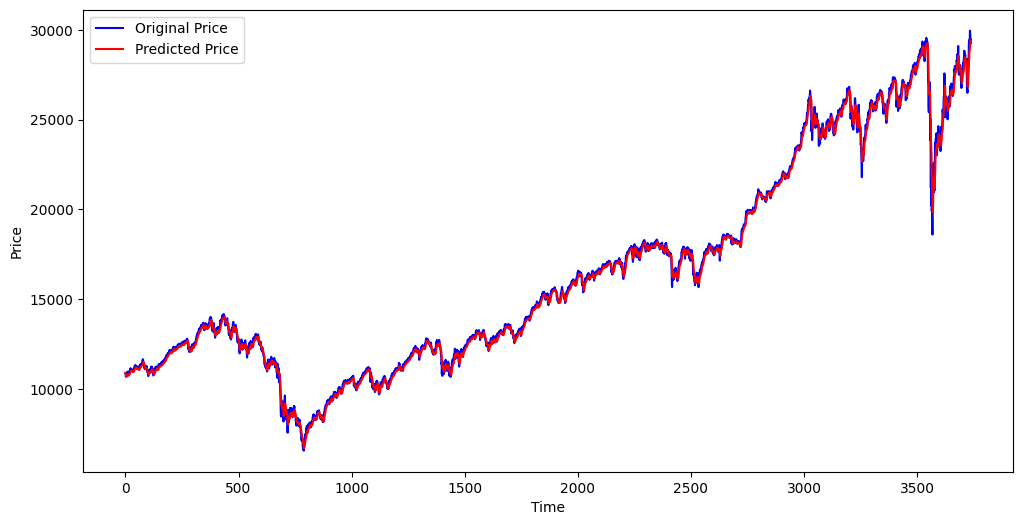

Plotting IXIC at k = 10
Model chosen: bidirectional
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean absolute error for k = 10: 66.94654605502559


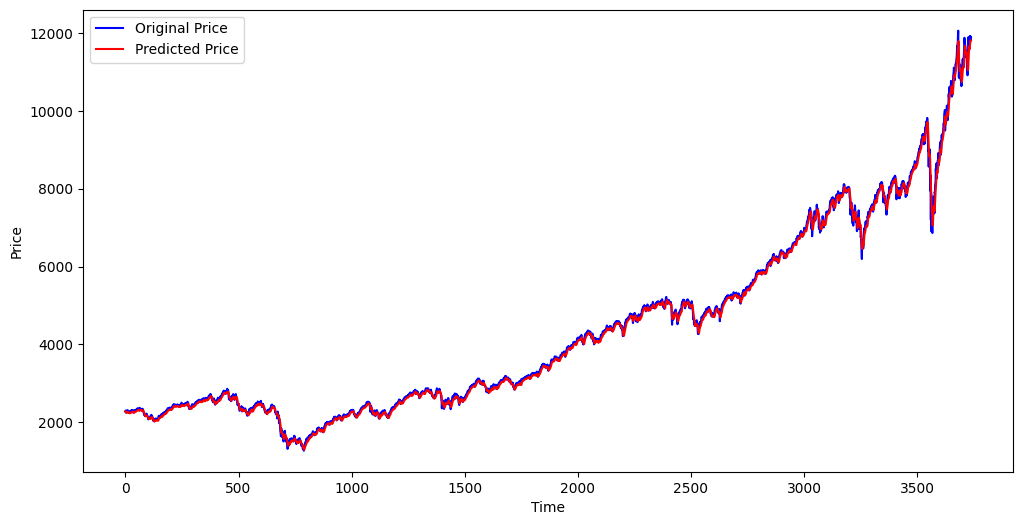

Plotting GSPC at k = 10
Model chosen: bidirectional
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean absolute error for k = 10: 22.126896337873273


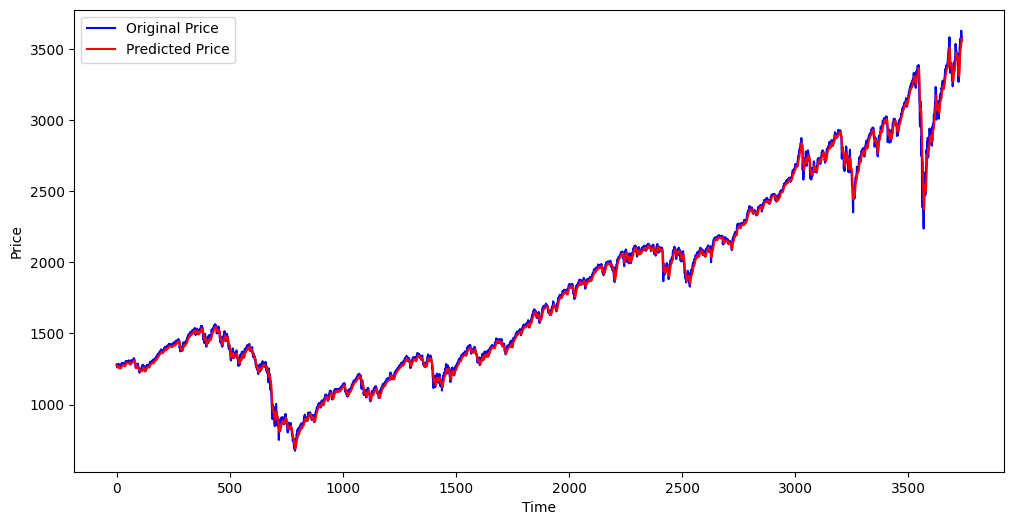

Plotting W5000 at k = 10
Model chosen: bidirectional
Testing for k = 10 models
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean absolute error for k = 10: 233.95244290636833


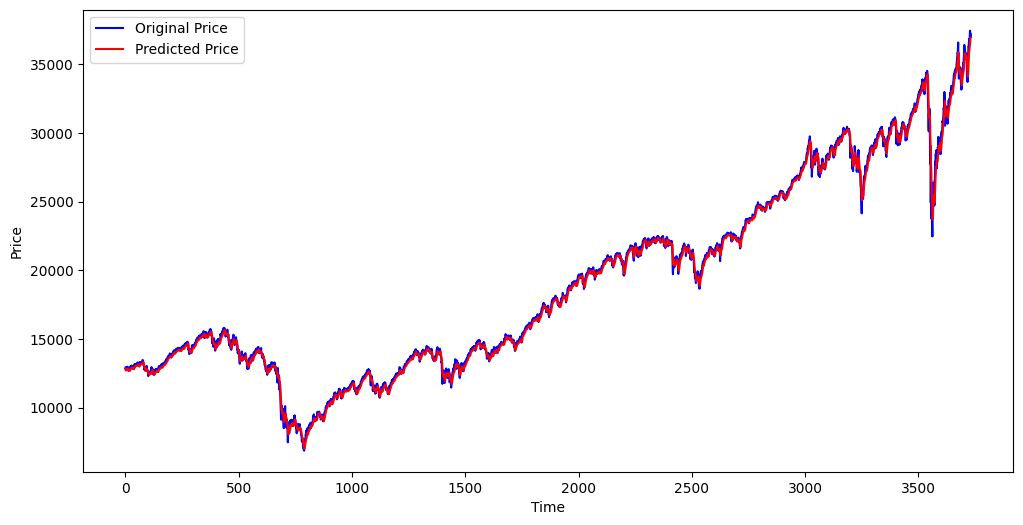

Plotting XLK at k = 60
Model chosen: CNN LSTM hybrid
Testing for k = 60 models
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean absolute error for k = 60: 0.6548110617417249


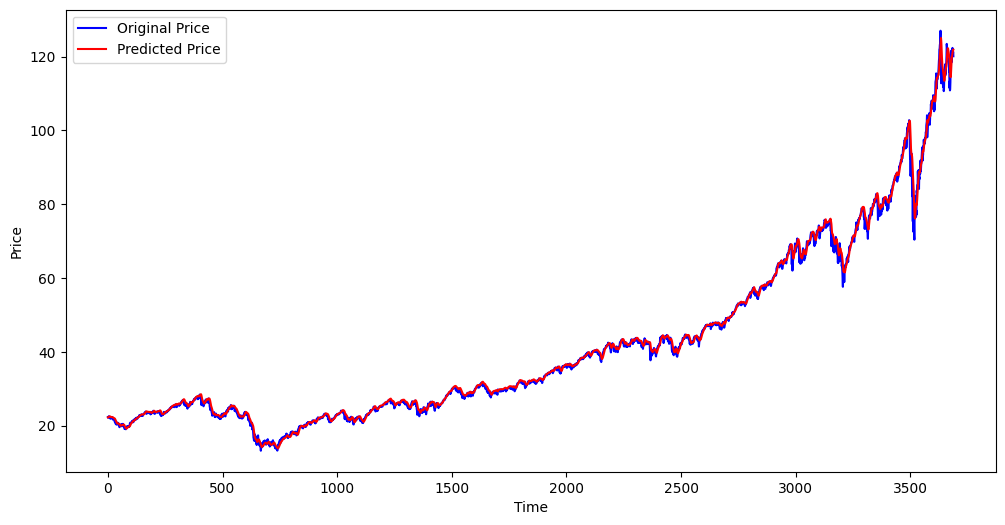

In [99]:
for i in range(len(indices)):
    print(f"Plotting {names[i]} at k = {best_ks[i]}")
    print(f"Model chosen: {best_models[i]}")
    if(best_models[i] == "regular"):
        test_on_index_and_plot_reg_LSTM_model(indices[i], best_ks[i], 'Y')
    elif(best_models[i] == "small"):
        test_on_index_and_plot_small_LSTM_model(indices[i], best_ks[i], 'Y')
    elif(best_models[i] == 'bidirectional'):
        test_on_index_and_plot_biLSTM_model(indices[i], best_ks[i], 'Y')
    elif(best_models[i] == "LSTM GRU hybrid"):
        test_on_index_and_plot_LSTM_GRU_hybrid_stocks_model(indices[i], best_ks[i], 'Y')
    elif(best_models[i] == "biLSTM GRU hybrid"):
        test_on_index_and_plot_biLSTM_GRU_hybrid_stocks_model(indices[i], best_ks[i], 'Y')
    elif(best_models[i] == "CNN LSTM hybrid"):
        test_on_index_and_plot_CNN_LSTM_hybrid_stocks_model(indices[i], best_ks[i], 'Y')
    elif(best_models[i] == "GRU CNN hybrid"):
        test_on_index_and_plot_gru_cnn_stocks_model(indices[i], best_ks[i], 'Y')
    else:
        test_on_index_and_plot_CNN_biLSTM_model(indices[i], best_ks[i], 'Y')

In [100]:
def eval_stocks_models(indices, names, yahoo_data):
    best_models = []
    best_ks = []
    models = ["regular", "small", "bidirectional", "LSTM GRU hybrid", "biLSTM GRU hybrid", "CNN LSTM hybrid", "GRU_CNN", "biLSTM_CNN_hybrid"]

    for i in range(len(indices)):
        best_mae, best_k = test_stocks_small_and_bi_LSTM_index(indices[i], names[i], 'N', yahoo_data[i])
        
        print(f"Best MAE on {names[i]} for regular LSTM = {best_mae['reg']} at k = {best_k['reg']}")
        print(f"Best MAE on {names[i]} for small LSTM = {best_mae['small']} at k = {best_k['small']}")
        print(f"Best MAE on {names[i]} for bidirectional LSTM = {best_mae['bi']} at k = {best_k['bi']}")
        print(f"Best MAE on {names[i]} for LSTM GRU hybrid = {best_mae['LSTM_GRU_hybrid']} at k = {best_k['LSTM_GRU_hybrid']}")
        print(f"Best MAE on {names[i]} for biLSTM GRU hybrid = {best_mae['biLSTM_GRU_hybrid']} at k = {best_k['biLSTM_GRU_hybrid']}")
        print(f"Best MAE on {names[i]} for CNN LSTM hybrid = {best_mae['CNN_LSTM_hybrid']} at k = {best_k['CNN_LSTM_hybrid']}")
        print(f"Best MAE on {names[i]} for GRU CNN hybrid = {best_mae['GRU_CNN']} at k = {best_k['GRU_CNN']}")
        print(f"Best MAE on {names[i]} for biLSTM CNN hybrid= {best_mae['biLSTM_CNN_hybrid']} at k = {best_k['biLSTM_CNN_hybrid']}")
        
        min_mae = min(best_mae.values())
        best_model = [model for model, mae in best_mae.items() if mae == min_mae][0]
        
        best_models.append(models[list(best_mae.keys()).index(best_model)])
        best_ks.append(best_k[best_model])
    
    return best_models, best_ks

### For plotting the best performing model for each stock

In [101]:
def plot_stocks_sector(stocks, names, best_models, best_ks, yahoo_data):
    for i in range(len(stocks)):
        print(f"Plotting {names[i]} at k = {best_ks[i]}")
        print(f"Model chosen: {best_models[i]}")
        if(best_models[i] == "regular"):
            test_on_index_and_plot_reg_LSTM_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        elif(best_models[i] == "small"):
            test_on_index_and_plot_small_LSTM_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        elif(best_models[i] == 'bidirectional'):
            test_on_index_and_plot_biLSTM_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        elif(best_models[i] == "LSTM GRU hybrid"):
            test_on_index_and_plot_LSTM_GRU_hybrid_stocks_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        elif(best_models[i] == "biLSTM GRU hybrid"):
            test_on_index_and_plot_biLSTM_GRU_hybrid_stocks_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        elif(best_models[i] == "CNN LSTM hybrid"):
            test_on_index_and_plot_CNN_LSTM_hybrid_stocks_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        elif(best_models[i] == "GRU CNN hybrid"):
            test_on_index_and_plot_gru_cnn_stocks_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])
        else:
            test_on_index_and_plot_CNN_biLSTM_model(stocks[i], best_ks[i], 'Y', yahoo_data[i])

### Taking a look at the performance of the models on healthcare stocks

In [102]:
amgn = yf.Ticker("AMGN")
amgn = amgn.history(period="1y")
abbv = yf.Ticker("ABBV")
abbv = abbv.history(period="1y")
abt = yf.Ticker("ABT")
abt = abt.history(period="1y")

In [103]:
amgn.iloc[0, 3:4]

Close    256.519043
Name: 2023-11-27 00:00:00-05:00, dtype: float64

In [104]:
health_stocks = [amgn, abbv, abt]
health_names = ["AMGN", "ABBV", "ABT"]
yahoo_data_h = ['Y', 'Y', 'Y']

In [105]:
best_models_health, best_ks_health = eval_stocks_models(health_stocks, health_names, yahoo_data_h)

Testing on the Regular LSTM for AMGN with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Mean absolute error for k = 10: 7.6113240869580405
Testing on the small LSTM for AMGN with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Mean absolute error for k = 10: 7.017385965552306
Testing on the Bidirectional LSTM for AMGN with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Mean absolute error for k = 10: 4.617892964490418
Testing on the LSTM GRU hybrid for AMGN with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
8/8 ━━━━━━━━━

In [106]:
best_models_health

['bidirectional', 'bidirectional', 'bidirectional']

In [107]:
best_ks_health

[10, 10, 10]

### Plotting the prices of 3 healthcare stocks, as predicted by the best model obtained above

Plotting AMGN at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Mean absolute error for k = 10: 4.617892964490418


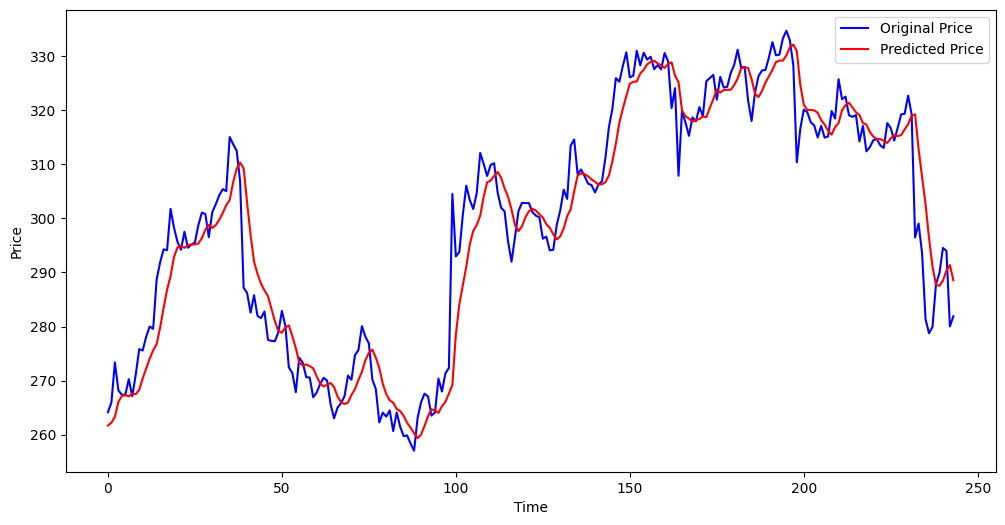

Plotting ABBV at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Mean absolute error for k = 10: 2.715643819093537


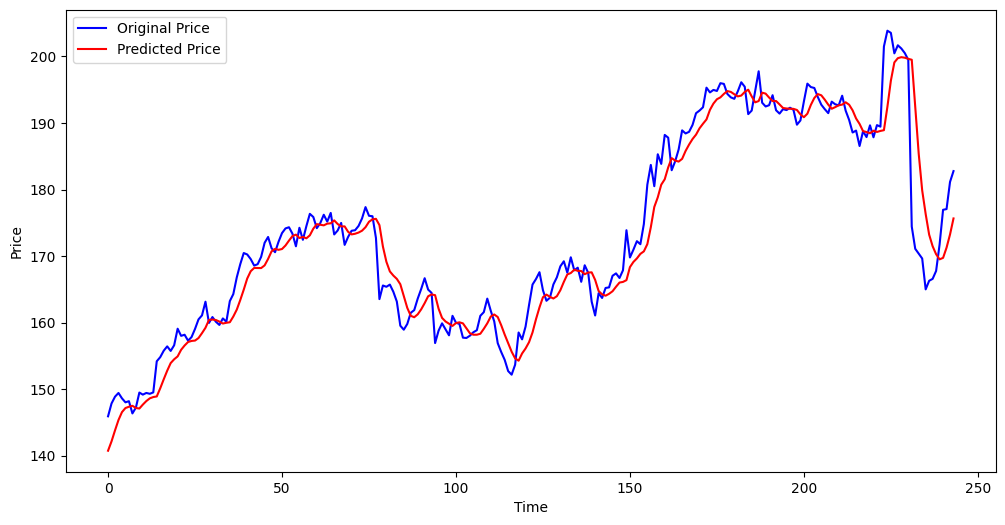

Plotting ABT at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Mean absolute error for k = 10: 1.24131120776882


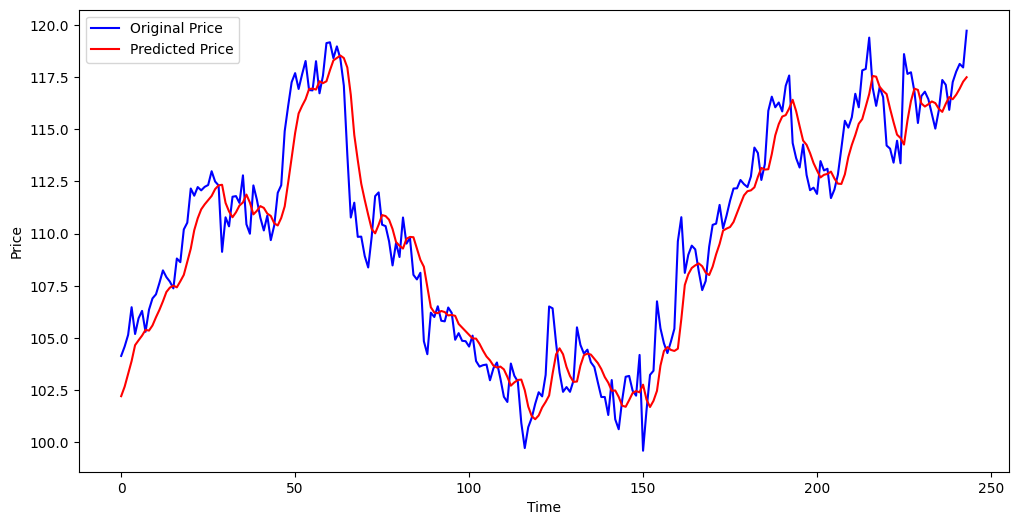

In [108]:
plot_stocks_sector(health_stocks, health_names, best_models_health, best_ks_health, yahoo_data_h)

### Taking a look at the performance of the models on tech stocks

In [109]:
intc = yf.Ticker("INTC")
intc = intc.history(period="1y")
amzn = yf.Ticker("AMZN")
amzn = amzn.history(period="1y")
meta = yf.Ticker("META")
meta = meta.history(period="1y")

In [110]:
tech_stocks = [intc, amzn, meta]
tech_names = ["INTC", "AMZN", "META"]
yahoo_data_t = ['Y', 'Y', 'Y']

In [111]:
best_models_tech, best_ks_tech = eval_stocks_models(tech_stocks, tech_names, yahoo_data_t)

Testing on the Regular LSTM for INTC with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Mean absolute error for k = 10: 1.6597781610098359
Testing on the small LSTM for INTC with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Mean absolute error for k = 10: 1.4888531864657635
Testing on the Bidirectional LSTM for INTC with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Mean absolute error for k = 10: 1.0294160468659792
Testing on the LSTM GRU hybrid for INTC with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
8/8 ━━━━━━━━

In [112]:
best_models_tech

['bidirectional', 'bidirectional', 'bidirectional']

In [113]:
best_ks_tech

[10, 10, 10]

### Plotting the prices of 3 tech stocks, as predicted by the best model obtained above

Plotting INTC at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Mean absolute error for k = 10: 1.0294160468659792


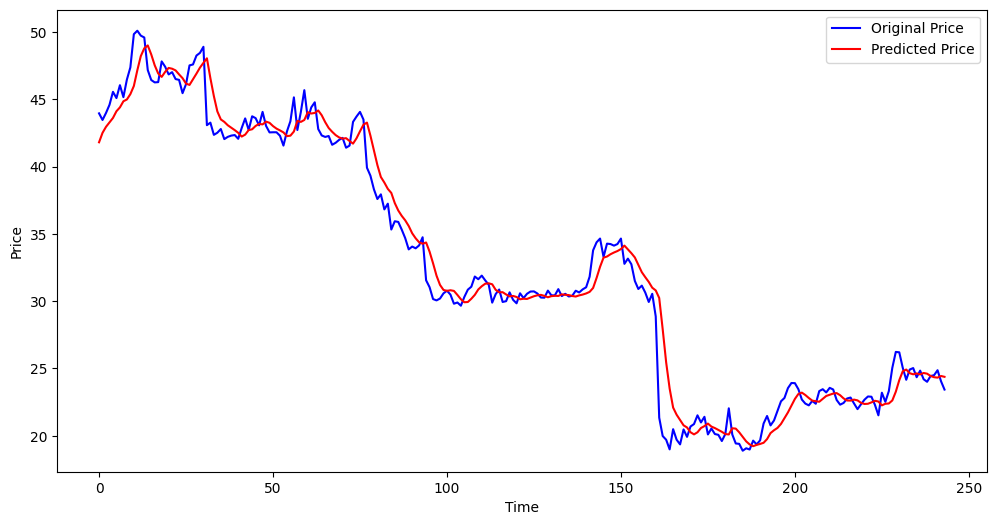

Plotting AMZN at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Mean absolute error for k = 10: 3.267092872511195


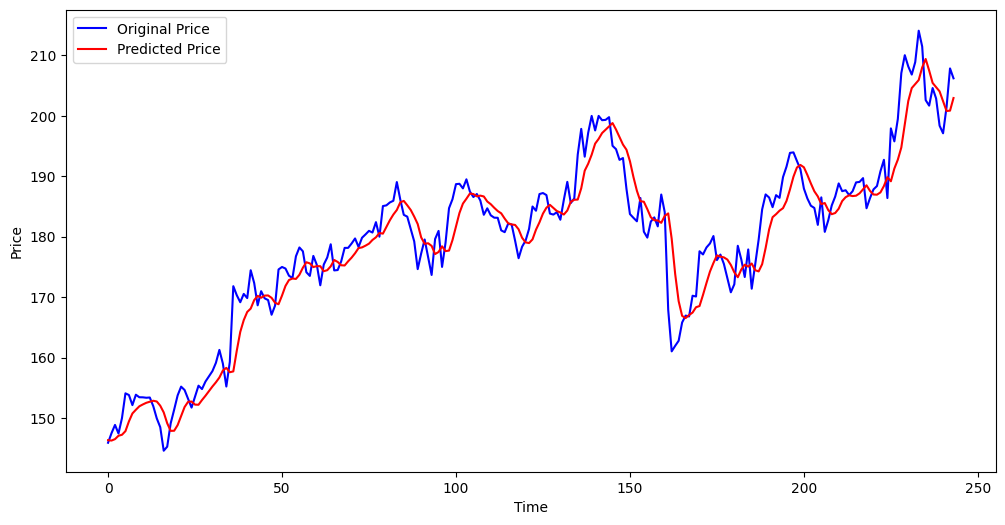

Plotting META at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Mean absolute error for k = 10: 10.379398715766548


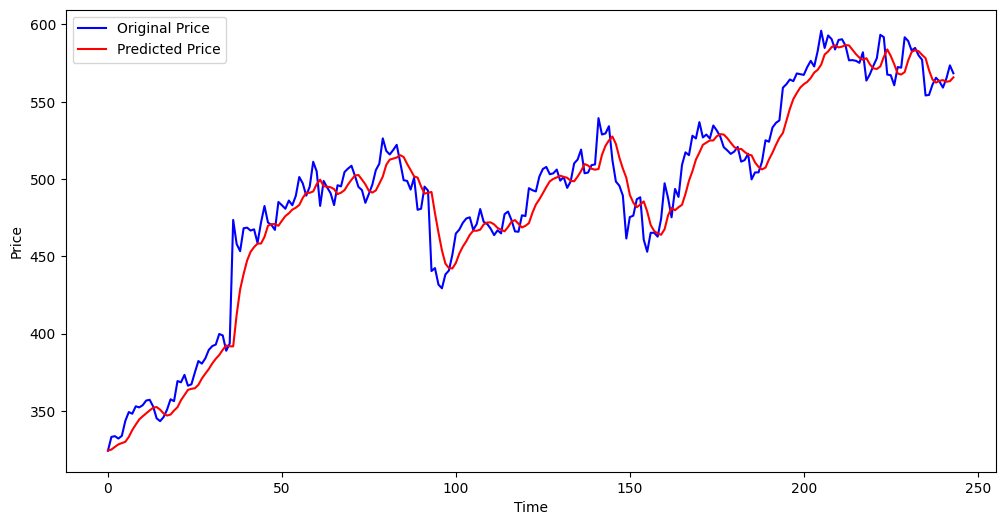

In [114]:
plot_stocks_sector(tech_stocks, tech_names, best_models_tech, best_ks_tech, yahoo_data_t)

## Taking a look at the performance on automotive stocks

In [115]:
tsla = yf.Ticker("TSLA")
tsla = tsla.history(period="1y")
gm = yf.Ticker("GM")
gm = gm.history(period="1y")
f = yf.Ticker("F")
f = f.history(period="1y")

In [116]:
auto_stocks = [tsla, gm, f]
auto_names = ["TSLA", "GM", "F"]
yahoo_data_a = ['Y', 'Y', 'Y']

In [117]:
best_models_auto, best_ks_auto = eval_stocks_models(auto_stocks, auto_names, yahoo_data_a)

Testing on the Regular LSTM for TSLA with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Mean absolute error for k = 10: 14.202508571270185
Testing on the small LSTM for TSLA with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Mean absolute error for k = 10: 13.083401951420008
Testing on the Bidirectional LSTM for TSLA with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean absolute error for k = 10: 8.700456375884325
Testing on the LSTM GRU hybrid for TSLA with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
8/8 ━━━━━━━━━

In [118]:
best_models_auto

['bidirectional', 'bidirectional', 'bidirectional']

In [119]:
best_ks_auto

[10, 10, 10]

### Plotting the prices of 3 auto stocks, as predicted by the best model obtained above

Plotting TSLA at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Mean absolute error for k = 10: 8.700456375884325


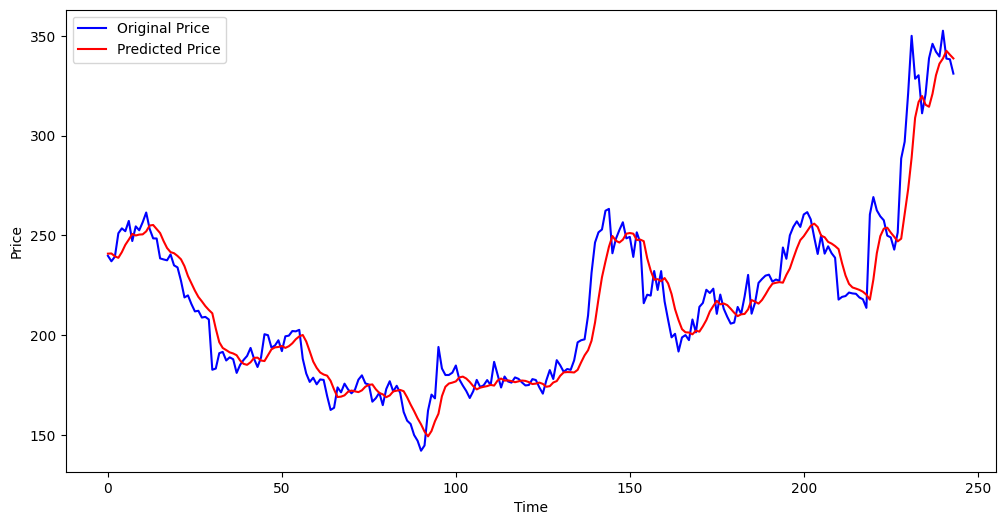

Plotting GM at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean absolute error for k = 10: 1.0425604590979565


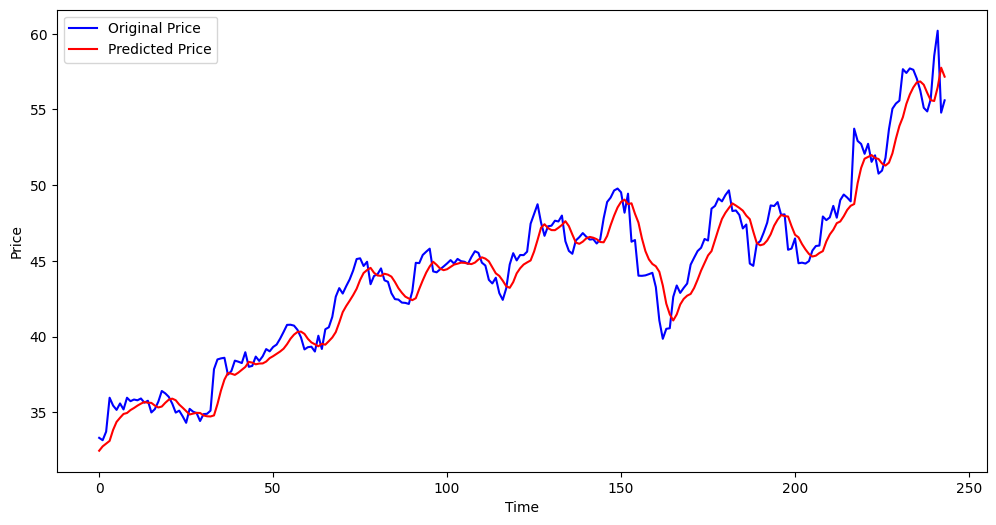

Plotting F at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Mean absolute error for k = 10: 0.2879890900006586


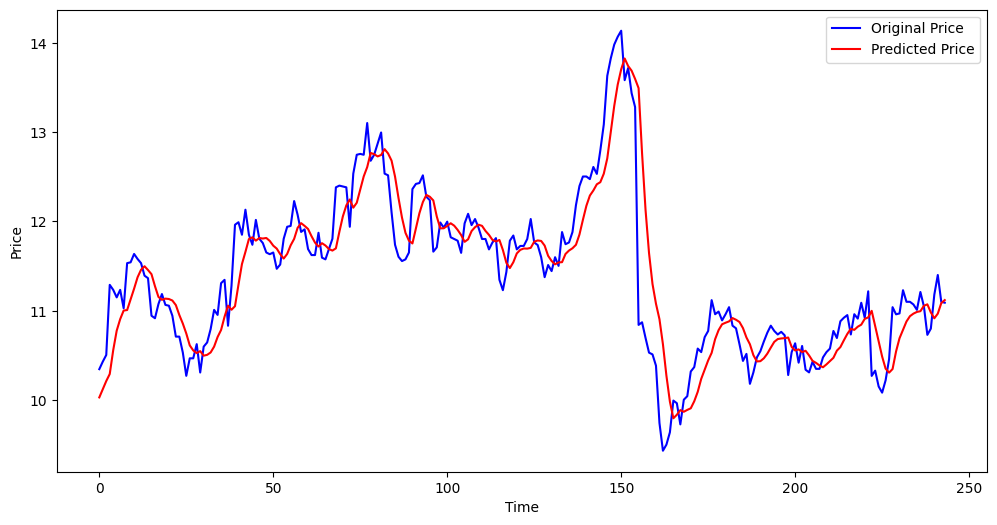

In [120]:
plot_stocks_sector(auto_stocks, auto_names, best_models_auto, best_ks_auto, yahoo_data_a)

## Taking a look at the performance on aerospace and defense stocks

In [121]:
ge = yf.Ticker("GE")
ge = ge.history(period="1y")
ba = yf.Ticker("BA")
ba = ba.history(period="1y")
rtx = yf.Ticker("RTX")
rtx = rtx.history(period="1y")

In [122]:
aero_stocks = [ge, ba, rtx]
aero_names = ["GE", "BA", "RTX"]
yahoo_data_ae = ['Y', 'Y', 'Y']

In [123]:
best_models_aero, best_ks_aero = eval_stocks_models(aero_stocks, aero_names, yahoo_data_ae)

Testing on the Regular LSTM for GE with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Mean absolute error for k = 10: 4.5349741243718595
Testing on the small LSTM for GE with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Mean absolute error for k = 10: 4.627459094973175
Testing on the Bidirectional LSTM for GE with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean absolute error for k = 10: 3.0037716221987383
Testing on the LSTM GRU hybrid for GE with k=10:
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━

In [124]:
best_models_aero

['bidirectional', 'bidirectional', 'bidirectional']

In [125]:
best_ks_aero

[10, 10, 10]

### Plotting the prices of 3 aerospace and defense stocks, as predicted by the best model obtained above

Plotting GE at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Mean absolute error for k = 10: 3.0037716221987383


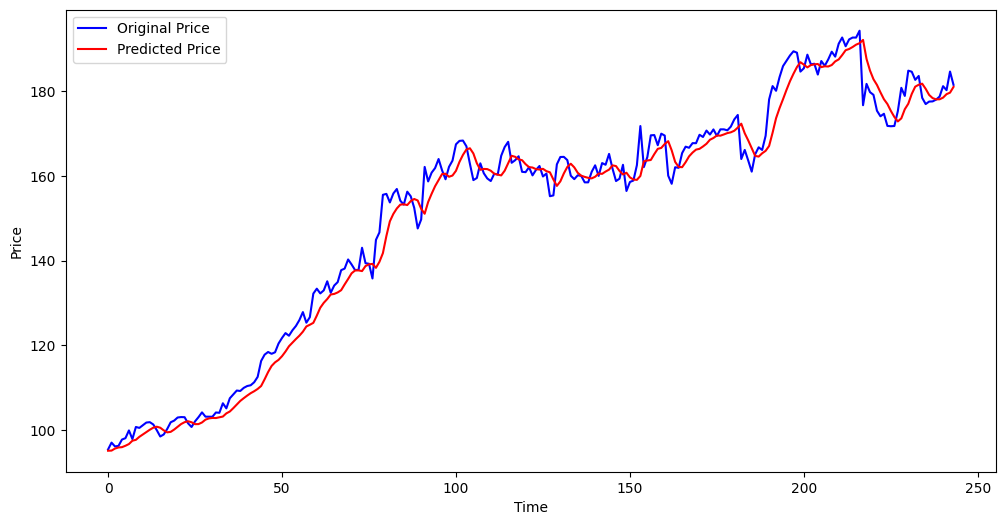

Plotting BA at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Mean absolute error for k = 10: 4.163216355269931


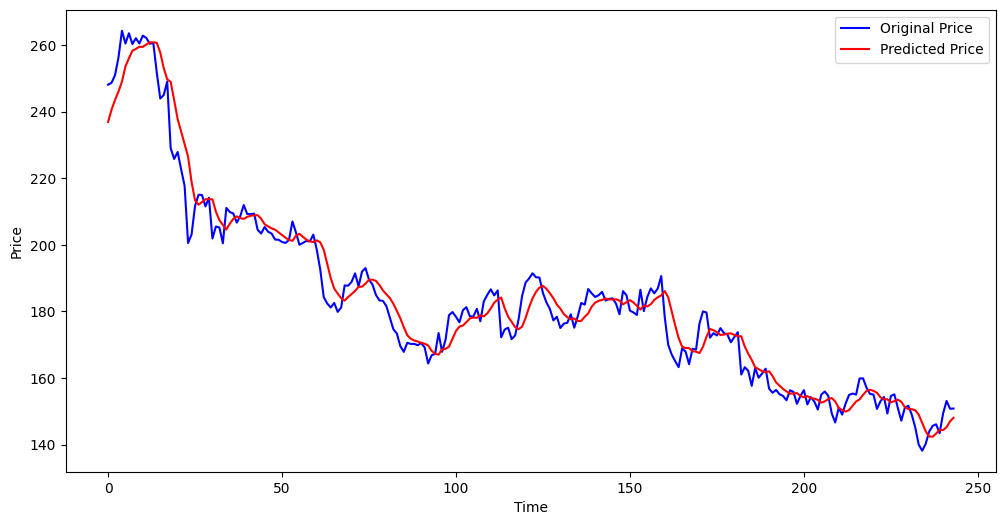

Plotting RTX at k = 10
Model chosen: bidirectional
Testing for k = 10 models
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Mean absolute error for k = 10: 1.2584145442288057


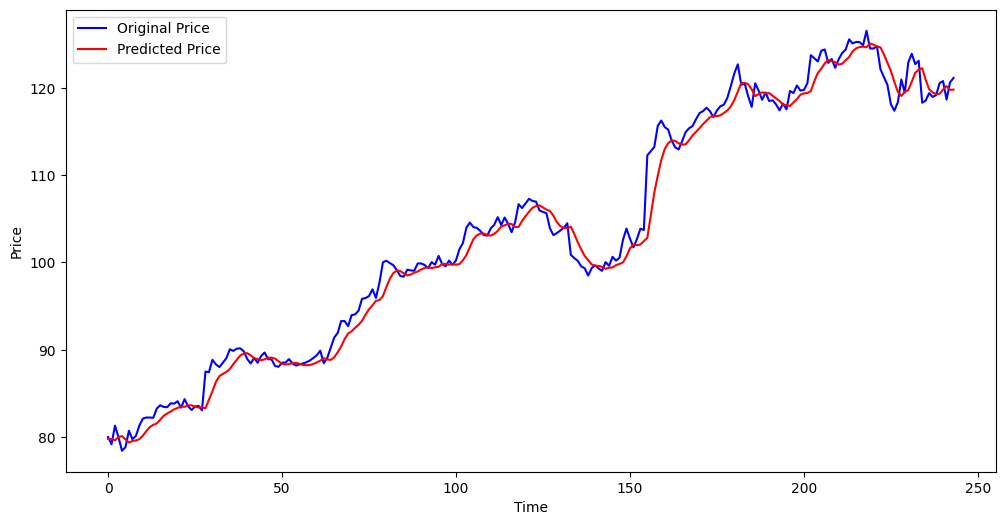

In [126]:
plot_stocks_sector(aero_stocks, aero_names, best_models_aero, best_ks_aero, yahoo_data_ae)